#load libraries

change runtime to gpu

In [ ]:


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import roc_auc_score

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
# !pip install tensorflow_text==2.0.0rc0
# !pip install tensorflow-gpu==1.10.0

# working
# !pip install tensorflow-gpu==1.15.0

In [ ]:
# !pip install bert-tensorflow
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.6MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=49cec65699bd17e3d95070c76857e6feb2dfdef1be8237454b58e6d4fa647c45
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=2a367a4eb305f7d0d93404b4aad300c4172a9ff7fd3fb70b899670fd54336cd2
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=fa0398d77d9cf3675e2b2cebd090dea1278a530d056b8b48832e29fa473b8b17
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:
# old version er jonne lagtise naile gives AttributeError: 'Tensor' object has no attribute 'numpy'
# tf.enable_eager_execution() 

In [ ]:
import bert
# from bert import run_classifier
# from bert import optimization
# from bert import tokenization
# from bert import modeling

In [ ]:
# import tokenization #error dey
# from keras.preprocessing.text import Tokenizer - bert.tokenization thakle ar dorkar nai

In [ ]:
print(tf.__version__)

2.2.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/Fake-vs-real/all_complete_labelled/'
bert_path = 'gdrive/My Drive/Colab Notebooks/BERT/'
colab_path = 'gdrive/My Drive/ColaCollecting bert-for-tf2b Notebooks/Datasets/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#Helper Functions:

In [ ]:

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(8, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

#Loading BERT from the Tensorflow Hub:

In [ ]:
%%time
# BERT multilingual - https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2
module_url = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2"
# module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 10.5 s, sys: 2.58 s, total: 13.1 s
Wall time: 20.7 s


#Loading data:

In [ ]:
df = pd.read_csv(root_path + "combined-1.csv", names = ['label','text','fullname','replies','retweet','likes'], skiprows=1)
#df = pd.read_csv(root_path + "ক্যান্সার-first-1000-stemmed.csv",names=['label','text'])

#df.drop(df.columns[[2,3,4,5,6,7]],axis = 1,inplace = True)
df.shape


(2067, 6)

In [ ]:
df.drop(df.columns[[2,3,4,5]],axis=1, inplace=True)

In [ ]:
df.head()

,label,text
0,FAKE,ডায়াবেটিস রুগীদের ডায়াবেটিস থেকে কিভাবে ওষুধ...
1,REAL,মায়ের ডায়াবেটিসে নবজাতকের ঝুঁকি দ্বিগুণ\n#ইত...
2,REAL,যাদের বয়স এবং লম্বা হিসাবের চেয়ে \nওজন বেশি ...
3,REAL,ডায়াবেটিস রোগীরা কেন ঝুঁকিতে জেনে নিন
4,REAL,"হৃদরোগ, ডায়াবেটিস, শ্বাসতন্ত্রের রোগ এবং হাইপ..."


#Pre processing steps

The function does the following:

* It replaces common texts found in the data and replaces that with our custom text
* It removes all emoji's and emoticons from the text
* It removes all English text

In [ ]:
import re
def replace_strings(texts, replace):
    new_texts=[]
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    
    regex = r'\b(?:(?:[0-9\u09E6-\u09EF]{1,2}[:/,.]){2}[0-9\u09E6-\u09EF]{2,4}|am|pm)\b'
    for text in texts:
        for r in replace:
            text=text.replace(r[0], r[1])

        text=emoji_pattern.sub(r'', text)
        text=english_pattern.sub(r'', text)
  
        if re.search(regex, text): # re.match() e pura string replace kore fele
          text = re.sub(regex, "<date>", text)
        
        #text = re.sub(r'[-!?]','',text)
        text=re.sub(r'\s+', ' ', text).strip()
        text = text.replace("\"","")
        text = text.replace(".","")
        new_texts.append(text)

    return new_texts

In [ ]:
#my_str = ["কথা_জমিয়ে '" "রাখতে নেই\nআত্নার ক্যান্সার। হয়?","আত্নার ক্যান্সার হয়"]

replace=[('\u200c', ' '),
         ('\u200d', ' '),
        ('\xa0', ' '),
        ('\n', ' '),
        ('\r', ' '),('&',''),('*',''),
         ('\"',' '),
         ('_',' '),
         ('?',' '),
         ('!',' '),
         ('।',' '),
         ('|',' '),
         ('#',' '),
         ('%',' '),
         ('/',' '),
         ('-',' '),
         (':',' '),
         ('<',' '),
         ('>',' '),
         ('(',' '),
         (')',' '),
         ('—',' '),
         ("'",' '),
         (',',' '),
         (';',' '),
         ('\\',' '),
         ('~',' '),
         ('”',''),
         ('•',' '),
         ('[',' '),
         (']',' '),
         ('{',' '),
         ('}',' '),
         ('“',' '),
         ('’',' '),
         ('‘',' ')
         ]

#new_str =replace_strings(my_str, replace)
df.text = replace_strings(df.text, replace)
#print(new_str)

In [ ]:
df.text[:5]

0    ডায়াবেটিস রুগীদের ডায়াবেটিস থেকে কিভাবে ওষুধ...
1    মায়ের ডায়াবেটিসে নবজাতকের ঝুঁকি দ্বিগুণ ইত্ত...
2    যাদের বয়স এবং লম্বা হিসাবের চেয়ে ওজন বেশি তা...
3               ডায়াবেটিস রোগীরা কেন ঝুঁকিতে জেনে নিন
4    হৃদরোগ ডায়াবেটিস শ্বাসতন্ত্রের রোগ এবং হাইপার...
Name: text, dtype: object

In [ ]:
# goal - remove whitespace

import string
df.text = df.text.str.strip()

In [ ]:
df.head()

,label,text
0,FAKE,ডায়াবেটিস রুগীদের ডায়াবেটিস থেকে কিভাবে ওষুধ...
1,REAL,মায়ের ডায়াবেটিসে নবজাতকের ঝুঁকি দ্বিগুণ ইত্ত...
2,REAL,যাদের বয়স এবং লম্বা হিসাবের চেয়ে ওজন বেশি তা...
3,REAL,ডায়াবেটিস রোগীরা কেন ঝুঁকিতে জেনে নিন
4,REAL,হৃদরোগ ডায়াবেটিস শ্বাসতন্ত্রের রোগ এবং হাইপার...


In [ ]:
#------------------------------
# A list of bangla stop words found from https://github.com/stopwords-iso/stopwords-bn/blob/master/stopwords-bn.json
#------------------------------

bn_stop_words = frozenset(["via","অতএব","অথচ","অথবা","অনুযায়ী","অনেক","অনেকে","অনেকেই","অন্তত","অন্য","অবধি","অবশ্য","অর্থাত","আই","আগামী","আগে","আগেই","আছে","আজ","আদ্যভাগে","আপনার","আপনি","আবার","আমরা","আমাকে","আমাদের","আমার","আমি","আর","আরও","ই","ইত্যাদি","ইহা","উচিত","উত্তর","উনি","উপর","উপরে","এ","এঁদের","এঁরা","এই","একই","একটি","একবার","একে","এক্","এখন","এখনও","এখানে","এখানেই","এটা","এটাই","এটি","এত","এতটাই","এতে","এদের","এব","এবং","এবার","এমন","এমনকী","এমনি","এর","এরা","এল","এস","এসে","ঐ","ও","ওঁদের","ওঁর","ওঁরা","ওই","ওকে","ওখানে","ওদের","ওর","ওরা","কখনও","কত","কবে","কমনে","কয়েক","কয়েকটি","করছে","করছেন","করতে","করবে","করবেন","করলে","করলেন","করা","করাই","করায়","করার","করি","করিতে","করিয়া","করিয়ে","করে","করেই","করেছিলেন","করেছে","করেছেন","করেন","কাউকে","কাছ","কাছে","কাজ","কাজে","কারও","কারণ","কি","কিংবা","কিছু","কিছুই","কিন্তু","কী","কে","কেউ","কেউই","কেখা","কেন","কোটি","কোন","কোনও","কোনো","ক্ষেত্রে","কয়েক","খুব","গিয়ে","গিয়েছে","গিয়ে","গুলি","গেছে","গেল","গেলে","গোটা","চলে","চান","চায়","চার","চালু","চেয়ে","চেষ্টা","ছাড়া","ছাড়াও","ছিল","ছিলেন","জন","জনকে","জনের","জন্য","জন্যওজে","জানতে","জানা","জানানো","জানায়","জানিয়ে","জানিয়েছে","জে","জ্নজন","টি","ঠিক","তখন","তত","তথা","তবু","তবে","তা","তাঁকে","তাঁদের","তাঁর","তাঁরা","তাঁাহারা","তাই","তাও","তাকে","তাতে","তাদের","তার","তারপর","তারা","তারৈ","তাহলে","তাহা","তাহাতে","তাহার","তিনঐ","তিনি","তিনিও","তুমি","তুলে","তেমন","তো","তোমার","থাকবে","থাকবেন","থাকা","থাকায়","থাকে","থাকেন","থেকে","থেকেই","থেকেও","দিকে","দিতে","দিন","দিয়ে","দিয়েছে","দিয়েছেন","দিলেন","দু","দুই","দুটি","দুটো","দেওয়া","দেওয়ার","দেওয়া","দেখতে","দেখা","দেখে","দেন","দেয়","দ্বারা","ধরা","ধরে","ধামার","নতুন","নয়","না","নাই","নাকি","নাগাদ","নানা","নিজে","নিজেই","নিজেদের","নিজের","নিতে","নিয়ে","নিয়ে","নেই","নেওয়া","নেওয়ার","নেওয়া","নয়","পক্ষে","পর","পরে","পরেই","পরেও","পর্যন্ত","পাওয়া","পাচ","পারি","পারে","পারেন","পি","পেয়ে","পেয়্র্","প্রতি","প্রথম","প্রভৃতি","প্রযন্ত","প্রাথমিক","প্রায়","প্রায়","ফলে","ফিরে","ফের","বক্তব্য","বদলে","বন","বরং","বলতে","বলল","বললেন","বলা","বলে","বলেছেন","বলেন","বসে","বহু","বা","বাদে","বার","বি","বিনা","বিভিন্ন","বিশেষ","বিষয়টি","বেশ","বেশি","ব্যবহার","ব্যাপারে","ভাবে","ভাবেই","মতো","মতোই","মধ্যভাগে","মধ্যে","মধ্যেই","মধ্যেও","মনে","মাত্র","মাধ্যমে","মোট","মোটেই","যখন","যত","যতটা","যথেষ্ট","যদি","যদিও","যা","যাঁর","যাঁরা","যাওয়া","যাওয়ার","যাওয়া","যাকে","যাচ্ছে","যাতে","যাদের","যান","যাবে","যায়","যার","যারা","যিনি","যে","যেখানে","যেতে","যেন","যেমন","র","রকম","রয়েছে","রাখা","রেখে","লক্ষ","শুধু","শুরু","সঙ্গে","সঙ্গেও","সব","সবার","সমস্ত","সম্প্রতি","সহ","সহিত","সাধারণ","সামনে","সি","সুতরাং","সে","সেই","সেখান","সেখানে","সেটা","সেটাই","সেটাও","সেটি","স্পষ্ট","স্বয়ং","হইতে","হইবে","হইয়া","হওয়া","হওয়ায়","হওয়ার","হচ্ছে","হত","হতে","হতেই","হন","হবে","হবেন","হয়","হয়তো","হয়নি","হয়ে","হয়েই","হয়েছিল","হয়েছে","হয়েছেন","হল","হলে","হলেই","হলেও","হলো","হাজার","হিসাবে","হৈলে","হোক","হয়"])

#train test split

In [ ]:
train, test, train_y, test_y = train_test_split(df['text'], df['label'],test_size = 0.3)
#y_train = train_df['label'].values

In [ ]:
train.head()

1190    মানুষ মানুষের জন্যে পর্ব ২ শিক্ষক রহমান সাহেবে...
1981    আল্লামা সাঈদীর মামলা শেখ হাসিনার ক্লোনিক ক্যান...
422         ডেঙ্গু থেকে সেরে উঠতে ঘরোয়া কার্যকরি উপায় @
653     মাত্র ৫ টাকায় কিডনি ক্লিন হবে জেনে নিন ঘরোয়া...
288           তালায় ডায়াবেটিস প্রতিরোধে মেডিকেল ক্যাম্প
Name: text, dtype: object

In [ ]:
test.head()

131               ডায়াবেটিস নিয়ন্ত্রণ করে তিতকুটে খাবার
2033                        যেসব কারণে ফুসফুসের ক্যান্সার
1779    ভালুকা মাস্টার হাসপাতালে বিশ্ব ক্যান্সার দিবস ...
1316    রেনিটিডিন উৎপাদন ও বিক্রিতে সাময়িক নিষেধাজ্ঞা...
880     ঘাড়ের ও গলার কালো দাগ দূর করার ঘরোয়া সহজ জাদ...
Name: text, dtype: object

#Loading tokenizer from the bert layer:

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
# tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)


#Encoding the text into tokens, masks, and segment flags:

In [ ]:
train_input = bert_encode(train.values, tokenizer, max_len=160)
test_input = bert_encode(test.values, tokenizer, max_len=160)
train_labels = train_y

In [ ]:
type(train_input)

tuple

In [ ]:
test_y

In [ ]:
print(train.shape)
print(train_y.shape)
print(test.shape)
print(test_y.shape)
print(train_labels.shape)

(1446,)
(1446,)
(621,)
(621,)
(1446,)


In [ ]:
type(train_labels)

pandas.core.series.Series

In [ ]:
train_labels = to_categorical(np.asarray(train_labels.factorize()[0]))

#Model: Build, Train, Predict

In [ ]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
#batch size = 16 e oom hoy, so use smaller batch size
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=50,
    batch_size=16
)


Epoch 1/50
73/73 [==============================] - 47s 641ms/step - loss: 1.7519 - accuracy: 0.3780 - val_loss: 1.5584 - val_accuracy: 0.4345
Epoch 2/50
73/73 [==============================] - 45s 622ms/step - loss: 1.4534 - accuracy: 0.4282 - val_loss: 1.3784 - val_accuracy: 0.4345
Epoch 3/50
73/73 [==============================] - 46s 628ms/step - loss: 1.2907 - accuracy: 0.4464 - val_loss: 1.2617 - val_accuracy: 0.5448
Epoch 4/50
73/73 [==============================] - 46s 626ms/step - loss: 1.1331 - accuracy: 0.5675 - val_loss: 1.1228 - val_accuracy: 0.6276
Epoch 5/50
73/73 [==============================] - 46s 626ms/step - loss: 0.9959 - accuracy: 0.6540 - val_loss: 1.0754 - val_accuracy: 0.6552
Epoch 6/50
73/73 [==============================] - 46s 627ms/step - loss: 0.9284 - accuracy: 0.6834 - val_loss: 1.0369 - val_accuracy: 0.6621
Epoch 7/50
73/73 [==============================] - 46s 627ms/step - loss: 0.8643 - accuracy: 0.6990 - val_loss: 1.0195 - val_accuracy: 0.6655

In [ ]:
#max accuracy 
print("Max acc from training set %0.5f" % max(train_history.history['accuracy']))
print("Max val_acc from validation set %0.5f" % max(train_history.history['val_accuracy']))

Max acc from training set 0.99221
Max val_acc from validation set 0.69655


#Predict

In [ ]:
y_pred = model.predict(test_input)

In [ ]:
test_y = to_categorical(np.asarray(test_y.factorize()[0]))

In [ ]:
print("test roc_auc_score %0.4f" %roc_auc_score(test_y,y_pred))

test roc_auc_score 0.6219


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = np.argmax(y_pred, axis=1)
accuracy_score(test_y, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, y_pred)

In [ ]:
y_pred.shape


(621, 8)

In [ ]:
test_y.shape

(621, 8)

In [ ]:
threshold =0.1 # this can be changed. For simplistic example, let uss consider 0.5
y_pred = np.where(y_pred <threshold,0,1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, y_pred, digits = 8))

#PLOT

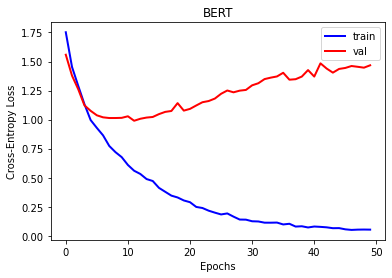

In [ ]:
#generate plots
from google.colab import files
test = plt.figure()
plt.plot(train_history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(train_history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('BERT')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

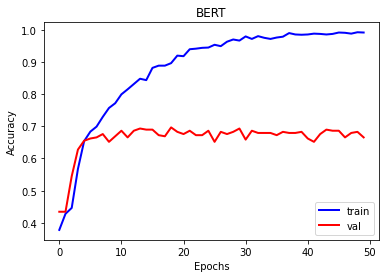

In [ ]:
test = plt.figure()
plt.plot(train_history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(train_history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('BERT')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()